In [1]:
#This model was partially trained because of lack of computational resources
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from customDataset import CatdogDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
gtpath="../catdogData/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../catdogData/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)

In [3]:
catdogdataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles)
train_size=int(0.8*len(catdogdataset))
test_size=len(catdogdataset)-train_size
trainset,testset=random_split(catdogdataset,[train_size,test_size],generator=torch.manual_seed(42))


In [4]:
model=RedCNN()
model

RedCNN(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [5]:
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
# ##Training

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)

# for epoch in range(5):
#     losses=[]
#     for i, data in enumerate(train_loader):
        
#         inputt, target=data
        
#         target_pred=model(inputt)
        
#         loss=criterion(target_pred,target)
#         losses.append(loss.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if (i%10==0):
#             print(f"Epoch: {epoch} Loss:{loss.item()} Batch:{i}")
        


In [7]:
# modelfile=".denoise.pth.tar"

# torch.save(model.state_dict(),modelfile)

In [8]:
modelfile="denoise.pth.tar"
loaded_model=RedCNN()
loaded_model.load_state_dict(torch.load(modelfile))


<All keys matched successfully>

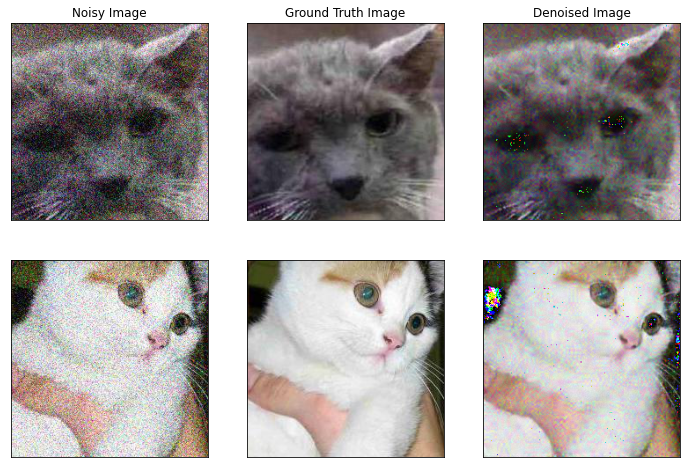

In [9]:
##Visualize the result with the image

input_image,target_image=testset[0]

input_image=input_image.view(-1,3,224,224)
target_image=target_image.view(-1,3,224,224)

input_image2,target_image2=testset[690]
input_image2=input_image2.view(-1,3,224,224)
target_image2=target_image2.view(-1,3,224,224)
with torch.no_grad():
    netoutput_image=loaded_model(input_image)
    netoutput_image2=loaded_model(input_image2)

    

fig, ax = plt.subplots(2, 3,figsize=(12, 8))


ax[0][0].imshow(np.transpose(input_image.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[0][1].imshow(np.transpose(target_image.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[0][2].imshow(np.transpose(netoutput_image.view(3,224,224).to(torch.uint8),(1,2,0)))

ax[1][0].imshow(np.transpose(input_image2.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[1][1].imshow(np.transpose(target_image2.view(3,224,224).to(torch.uint8),(1,2,0)))
ax[1][2].imshow(np.transpose(netoutput_image2.view(3,224,224).to(torch.uint8),(1,2,0)))

# Add titles to each subplot
ax[0][0].set_title('Noisy Image')
ax[0][1].set_title('Ground Truth Image')
ax[0][2].set_title('Denoised Image')

# # Remove the x and y ticks
for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Show the plot
plt.show()



In [10]:
#testing 
import cv2

for batch in train_loader:
    psnr=[]
    img=batch[0].detach().numpy()
    recon_image=loaded_model(batch[0]).detach().numpy()
    for i in range(len(batch[0])):
        psnr.append(cv2.PSNR(img[i],recon_image[i]))
    print(cv2.PSNR(img,recon_image))
    break
    


20.199572517632767


In [11]:
psnr=[]

for i in range(len(trainset)):
    noise,gt=trainset[i]
    psnr.append(cv2.PSNR(noise.numpy(),gt.numpy()))

In [12]:
sum(psnr)/len(psnr)

18.751168014649505